In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0,'../code/data_utils/')
from HiCDataset import HiCDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
#path = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/GM_ins_w1_fraction0.8/chrom_12_107.76/experimental_score.txt'
save_folder = './insulation_scores/'
path = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/GM_ins_w1_fraction0.5/chrom_12_107.76/experimental_score.txt'

In [3]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [4]:
#path1 = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/GM_ins_w1_fraction0.8/chrom_12_107.76/generated_score.txt'
#base_directory = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/GM_ins_w1_fraction0.8/'
path1 = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/GM_ins_w1_fraction0.5/chrom_12_107.76/generated_score.txt'
base_directory = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/GM_ins_w1_fraction0.5/'
base_tan_directory = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/GM_ins_w1_fraction_Tan_vs_HiC/'
base_imr_directory = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/full_scan/IMR_ins_w1_fraction0.5/'


In [5]:
def process_val(val):
    if 'nan' in val:
        return torch.nan
    return float(val.replace('\n',''))

def load_data(fp):
    return torch.tensor([
        process_val(val) for val in open(fp,'r').readlines()
    ])

def corrcoef(data1,data2):
    return torch.corrcoef(
        torch.stack(
            [
                data1[8:-8], # 8 to ignore nan values on edges
                data2[8:-8]
            ],
            dim=0
        )
    )[0,1]


In [6]:
chrom_sizes = HiCDataset('../data/outside/GM12878_hg19.mcool').clr.chromsizes
def load_chromosome(chrom,resolution=20_000,num_beads=64,base_directory = base_directory):

    vals = {
        'Generated':torch.empty(chrom_sizes[chrom] // resolution).fill_(torch.nan)
    }
    vals['Experimental'] = vals['Generated'].clone()
    vals['PCC'] = vals['Generated'].clone()


    dir_name_start = f'chrom_{chrom}_'
    n = len(dir_name_start)
    for d in os.listdir(base_directory):

        if (not os.path.isdir(base_directory + d) ) or (dir_name_start != d[:n]):
            continue

        start_idx = int( round( 1000* float(d.split('_')[-1]) / 20) )
        stop_idx = start_idx + num_beads

        fp = base_directory + d + '/generated_score.txt'
        gen_data = load_data(fp)
        vals['Generated'][start_idx:stop_idx] = gen_data

        fp = base_directory + d + '/experimental_score.txt'
        exp_data = load_data(fp)
        vals['Experimental'][start_idx:stop_idx] = exp_data

        vals['PCC'][(start_idx+stop_idx)//2] = corrcoef(gen_data,exp_data)

    return vals
    
    
def load_all_data(*args,**kwargs):
    data = {}
    for chrom in [*[str(k) for k in range(1,23)],'X']:
        data[chrom] = load_chromosome(chrom,*args,**kwargs)
    return data
'''
def plot_all_data(data,resolution=20_000):

    chroms = [*[str(k) for k in range(1,23)],'X']
    
    exp = torch.cat([
        data[chrom]['Experimental'] for chrom in chroms
    ])
    gen = torch.cat([
        data[chrom]['Generated'] for chrom in chroms
    ])
    pcc = torch.cat([
        data[chrom]['PCC'] for chrom in chroms
    ])

    #x = torch.cat([
    #    torch.arange(len(data[chrom]['PCC'])) * resolution / 1e6 for chrom in chroms
    #])

    chrom_boundaries = [0]
    for chrom in chroms:
        chrom_boundaries.append(len(data[chrom]['PCC'])+chrom_boundaries[-1])
    
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(12,3))

    #axes = (axes[0][0],axes[1][0])
    
    #
    ax = axes[0]
    ax.plot(exp,label='Experimental')
    ax.plot(gen,label='Generated')
    for cb in chrom_boundaries:
        axes[0]
    ax.legend()
    ax.set_xlabel('Monomer index')
    ax.set_ylabel('Insulation score')

    ax = axes[1]
    ax.plot(pcc,'.')
    ax.set_xlabel('Monomer index')
    ax.set_ylabel('PCC')

    #
    ax1_ylims = axes[0].get_ylim()
    ax2_ylims = axes[1].get_ylim()
    for cb in chrom_boundaries[1:-1]:
        axes[0].plot([cb,cb],ax1_ylims,'k',alpha=.5)
        axes[1].plot([cb,cb],ax2_ylims,'k',alpha=.5)

    axes[0].set_ylim(ax1_ylims)
    axes[1].set_ylim(ax2_ylims)
'''

from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_all_data(data,resolution=20_000):

    chroms = [*[str(k) for k in range(1,23)],'X']
    
    exp = torch.cat([
        data[chrom]['Experimental'] for chrom in chroms
    ])
    gen = torch.cat([
        data[chrom]['Generated'] for chrom in chroms
    ])
    pcc = torch.cat([
        data[chrom]['PCC'].clone() for chrom in chroms # Clone to ensure no in-place nonsense happens since we need these values for the histogram
    ])

    #x = torch.cat([
    #    torch.arange(len(data[chrom]['PCC'])) * resolution / 1e6 for chrom in chroms
    #])

    chrom_boundaries = [0]
    for chrom in chroms:
        chrom_boundaries.append(len(data[chrom]['PCC'])+chrom_boundaries[-1])
    
    fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(12,4.5))

    #axes = (axes[0][0],axes[1][0])
    
    #
    ax = axes[0]
    ax.plot(exp,label='Experimental')
    ax.plot(gen,label='Generated')
    for cb in chrom_boundaries:
        axes[0]
    ax.legend()
    #ax.set_xlabel('Monomer index')
    ax.set_ylabel('Insulation score')
    ax.set_xlim([0,len(pcc)])

    ax = axes[1]
    ax.plot(pcc,'.')
    #ax.set_xlabel('Monomer index')
    ax.set_ylabel('PCC')
    ax.set_xlim([0,len(pcc)])

    #
    ax1_ylims = axes[0].get_ylim()
    ax2_ylims = axes[1].get_ylim()
    for cb in chrom_boundaries[1:-1]:
        axes[0].plot([cb,cb],ax1_ylims,'k',alpha=.5)
        axes[1].plot([cb,cb],ax2_ylims,'k',alpha=.5)

    axes[0].set_ylim(ax1_ylims)
    axes[1].set_ylim(ax2_ylims)

    # 
    ax = axes[2]

    idx = torch.where(pcc.isfinite())[0]
    for i in idx:
        pcc[i-28:i+28] = pcc[i]

    #ax.matshow(pcc.reshape(1,len(pcc)).expand(int(.1*len(pcc)),-1),vmin=-1,vmax=1,cmap='PRGn')
    im = ax.matshow(pcc.unsqueeze(0),vmin=-1,vmax=1,cmap='PRGn')

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", fraction=.02)#size="2%",pad=-.05)#, pad=0.05)
    #cbar = fig.colorbar(im,cax=cax)
    cbar = fig.colorbar(im,fraction=.02,label='$\\rho$')
    #cbar.ax.set_aspect( ax.get_aspect() * .02 )
    #im = ax.matshow(pcc.unsqueeze(0),vmin=-1,vmax=1,cmap='PRGn')
    ax.set_aspect(int(.1*len(pcc)))
    ax.set_yticks([])
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.set_xlabel('Genomic index')
    ax.set_xticks([cb for cb in chrom_boundaries])
    ax.set_xticklabels([])

    return fig 
    
    

In [7]:
chrom_sizes = HiCDataset('../data/outside/GM12878_hg19.mcool').clr.chromsizes
def load_chromosome(chrom,resolution=20_000,num_beads=64,base_directory = base_directory):

    vals = {
        'Generated':torch.empty(chrom_sizes[chrom] // resolution).fill_(torch.nan)
    }
    vals['Experimental'] = vals['Generated'].clone()
    vals['PCC'] = vals['Generated'].clone()


    dir_name_start = f'chrom_{chrom}_'
    n = len(dir_name_start)
    for d in os.listdir(base_directory):

        if (not os.path.isdir(base_directory + d) ) or (dir_name_start != d[:n]):
            continue

        start_idx = int( round( 1000* float(d.split('_')[-1]) / 20) )
        stop_idx = start_idx + num_beads

        fp = base_directory + d + '/generated_score.txt'
        gen_data = load_data(fp)
        vals['Generated'][start_idx:stop_idx] = gen_data

        fp = base_directory + d + '/experimental_score.txt'
        exp_data = load_data(fp)
        vals['Experimental'][start_idx:stop_idx] = exp_data

        vals['PCC'][(start_idx+stop_idx)//2] = corrcoef(gen_data,exp_data)

    return vals
    
    
def load_all_data(*args,**kwargs):
    data = {}
    for chrom in [*[str(k) for k in range(1,23)],'X']:
        data[chrom] = load_chromosome(chrom,*args,**kwargs)
    return data
'''
def plot_all_data(data,resolution=20_000):

    chroms = [*[str(k) for k in range(1,23)],'X']
    
    exp = torch.cat([
        data[chrom]['Experimental'] for chrom in chroms
    ])
    gen = torch.cat([
        data[chrom]['Generated'] for chrom in chroms
    ])
    pcc = torch.cat([
        data[chrom]['PCC'] for chrom in chroms
    ])

    #x = torch.cat([
    #    torch.arange(len(data[chrom]['PCC'])) * resolution / 1e6 for chrom in chroms
    #])

    chrom_boundaries = [0]
    for chrom in chroms:
        chrom_boundaries.append(len(data[chrom]['PCC'])+chrom_boundaries[-1])
    
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(12,3))

    #axes = (axes[0][0],axes[1][0])
    
    #
    ax = axes[0]
    ax.plot(exp,label='Experimental')
    ax.plot(gen,label='Generated')
    for cb in chrom_boundaries:
        axes[0]
    ax.legend()
    ax.set_xlabel('Monomer index')
    ax.set_ylabel('Insulation score')

    ax = axes[1]
    ax.plot(pcc,'.')
    ax.set_xlabel('Monomer index')
    ax.set_ylabel('PCC')

    #
    ax1_ylims = axes[0].get_ylim()
    ax2_ylims = axes[1].get_ylim()
    for cb in chrom_boundaries[1:-1]:
        axes[0].plot([cb,cb],ax1_ylims,'k',alpha=.5)
        axes[1].plot([cb,cb],ax2_ylims,'k',alpha=.5)

    axes[0].set_ylim(ax1_ylims)
    axes[1].set_ylim(ax2_ylims)
'''

from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_all_data(data,resolution=20_000):

    chroms = [*[str(k) for k in range(1,23)],'X']
    
    exp = torch.cat([
        data[chrom]['Experimental'] for chrom in chroms
    ])
    gen = torch.cat([
        data[chrom]['Generated'] for chrom in chroms
    ])
    pcc = torch.cat([
        data[chrom]['PCC'].clone() for chrom in chroms # Clone to ensure no in-place nonsense happens since we need these values for the histogram
    ])

    chrom_boundaries = [0]
    for chrom in chroms:
        chrom_boundaries.append(len(data[chrom]['PCC'])+chrom_boundaries[-1])
    
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,1.5))

    idx = torch.where(pcc.isfinite())[0]
    for i in idx:
        pcc[i-28:i+28] = pcc[i]

    #ax.matshow(pcc.reshape(1,len(pcc)).expand(int(.1*len(pcc)),-1),vmin=-1,vmax=1,cmap='PRGn')
    im = ax.matshow(pcc.unsqueeze(0),vmin=-1,vmax=1,cmap='PRGn')

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", fraction=.02)#size="2%",pad=-.05)#, pad=0.05)
    #cbar = fig.colorbar(im,cax=cax)
    cbar = fig.colorbar(im,fraction=.02,label='$\\rho$')
    #cbar.ax.set_aspect( ax.get_aspect() * .02 )
    #im = ax.matshow(pcc.unsqueeze(0),vmin=-1,vmax=1,cmap='PRGn')
    ax.set_aspect(int(.02*len(pcc)))
    ax.set_yticks([])
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.set_xlabel('Genomic index')
    ax.set_xticks([cb for cb in chrom_boundaries])
    ax.set_xticklabels([*['$\\mathdefault{'+f'{k}'+'}$' for k in range(1,23)],'X',''])

    return fig 
    
    

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'X', 'c', 'd', 'e', 'eight', 'five', 'four', 'i', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 42, 59, 70, 71, 72, 76, 80, 81, 82, 91, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 26 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'X', 'c', 'd', 'e', 'eight', 'five', 'four', 'i', 'm', 'minus', 'n', 'nine', 'nonmarkingr

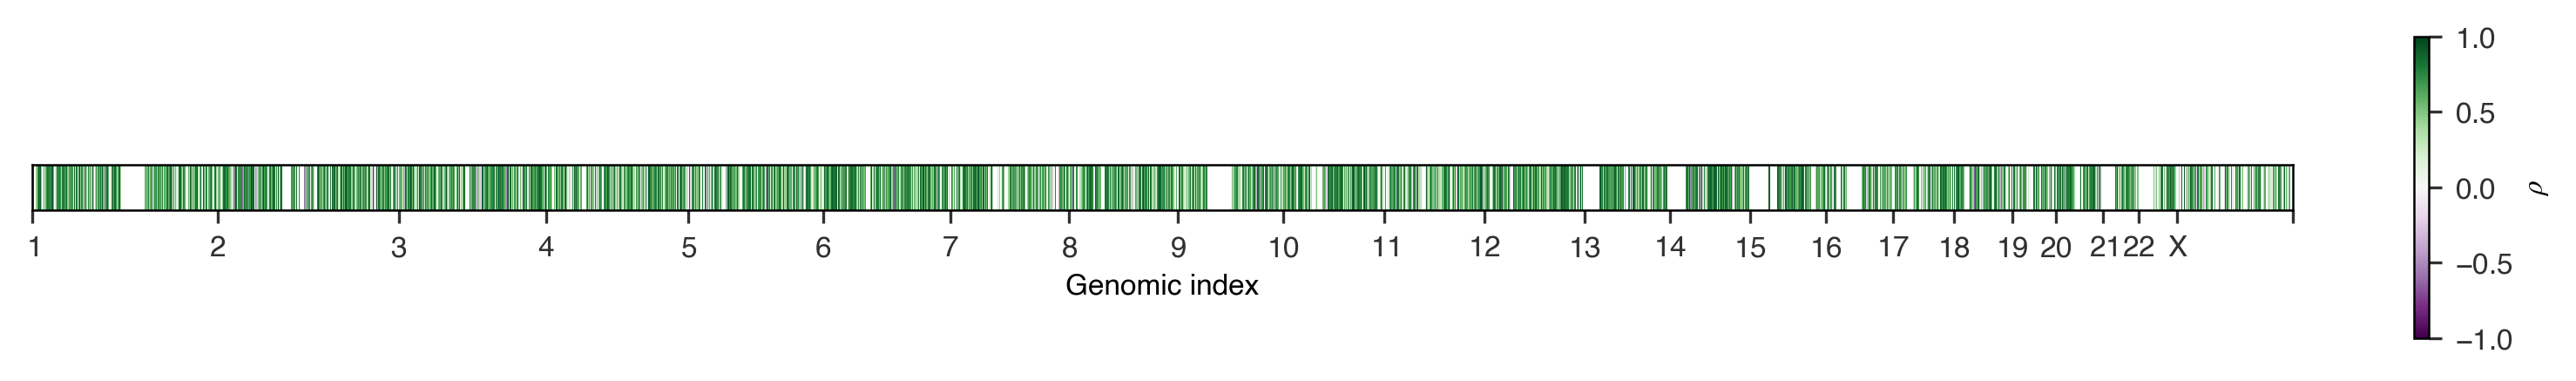

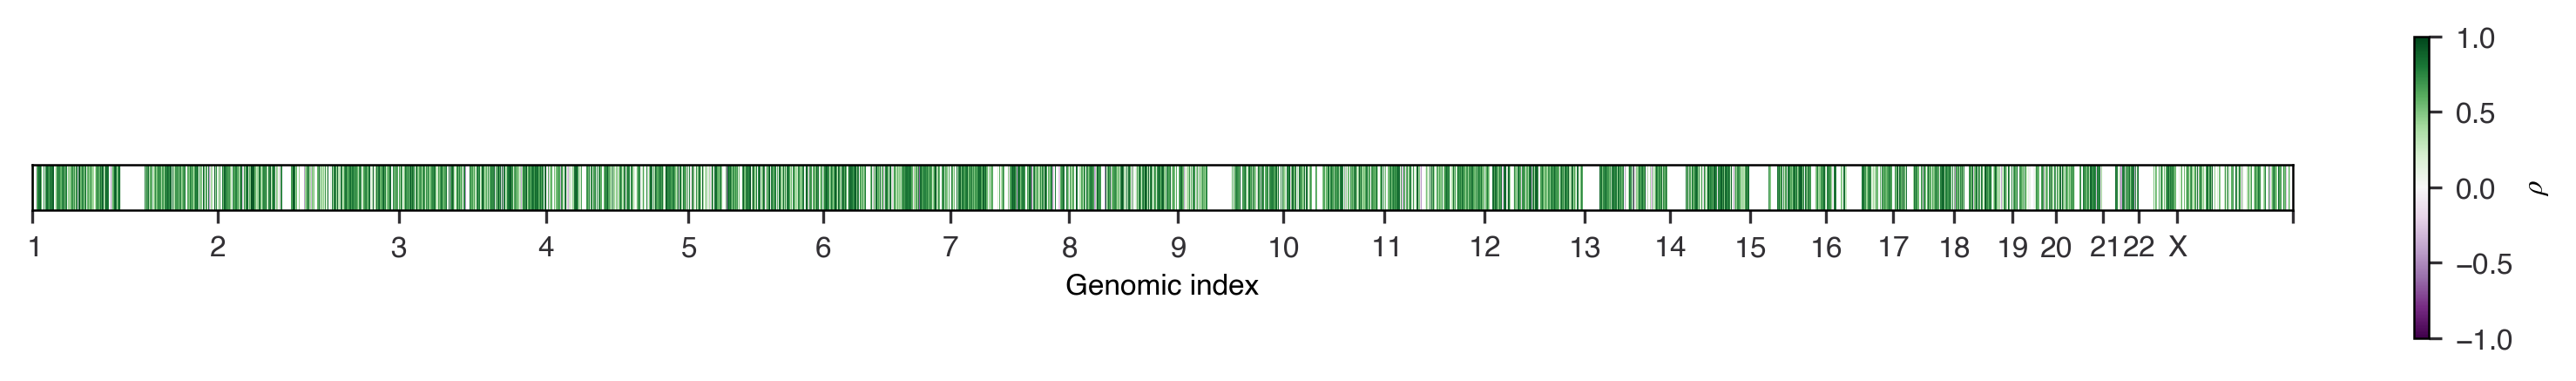

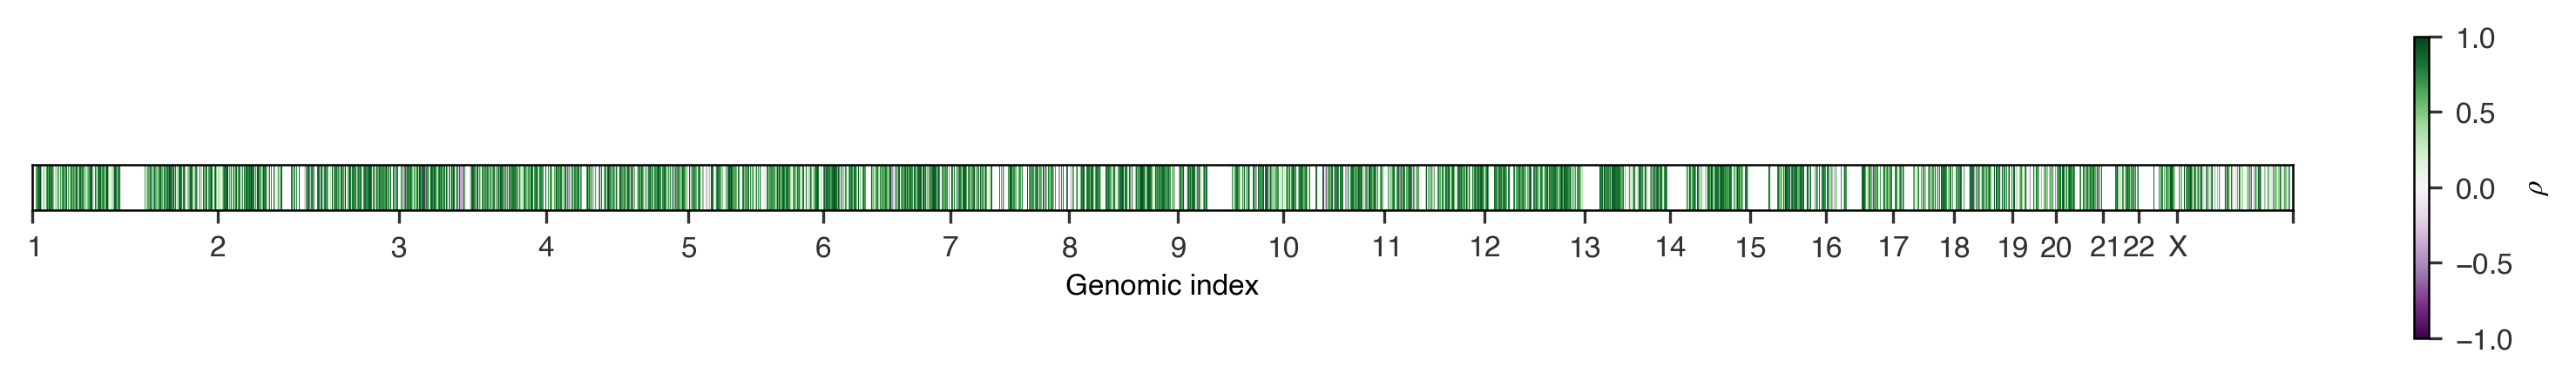

In [8]:
while True:
    try:
        fig = plot_all_data(data)
        fig.savefig(save_folder + 'genome_wide.pdf')
        fig = plot_all_data(tan_data)
        fig.savefig(save_folder + 'genome_wide_dip_c.pdf')
        fig = plot_all_data(imr_data)
        fig.savefig(save_folder + 'genome_wide_imr.pdf')
        break
    except:
        data = load_all_data()
        tan_data = load_all_data(base_directory=base_tan_directory)
        imr_data = load_all_data(base_directory=base_imr_directory)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 33 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'H', 'P', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'hyphen', 'i', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 38, 39, 42, 43, 51, 68, 69, 70, 71, 72, 73, 76, 79, 81, 82, 83, 85, 86, 87, 88, 89, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 35 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'H', 'P', 'a', 'b', 'c', 'd', '

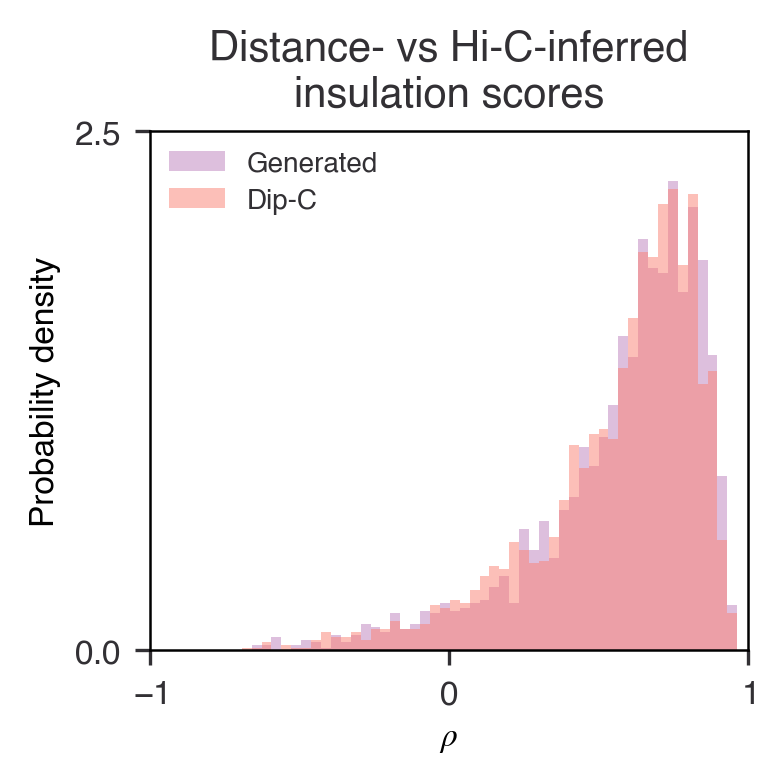

In [9]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(2.5,2.5),layout='constrained')
nbins = 50


pcc_gen = torch.cat([
    data[chrom]['PCC'] for chrom in data
])
pcc_gen = pcc_gen[pcc_gen.isfinite()]

tan_pcc = torch.cat([
    tan_data[chrom]['PCC'] for chrom in tan_data
])
tan_pcc = tan_pcc[tan_pcc.isfinite()]

minn = min( pcc_gen.min(), tan_pcc.min()  )
maxx = max( pcc_gen.max(), tan_pcc.max()  )
delta = (maxx - minn)/nbins
bins = torch.arange(minn,maxx+delta/2,delta)

for pcc,label in [(pcc_gen,'Generated'),(tan_pcc,'Dip-C')]:

    ax.hist(pcc.flatten().cpu().numpy(),density=True,label=label,bins=bins,alpha=.5,edgecolor='none')

ax.legend(framealpha=0,fontsize='small',loc='upper left')
ax.set_xlim([-1,1])
ax.set_xticks([-1,0,1])
ax.set_ylim([0,2.5])
ax.set_yticks([0,2.5])
ax.set_xlabel('$\\rho$')
ax.set_ylabel('Probability density')
ax.set_title('Distance- vs Hi-C-inferred\ninsulation scores')

fig.savefig(save_folder+'histogram.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'H', 'I', 'M', 'P', 'R', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'hyphen', 'i', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'space', 't', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 28, 38, 39, 43, 44, 48, 51, 53, 68, 69, 70, 71, 72, 73, 76, 79, 81, 82, 85, 86, 87, 88, 89, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 37 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'H', 'I', 'M', 

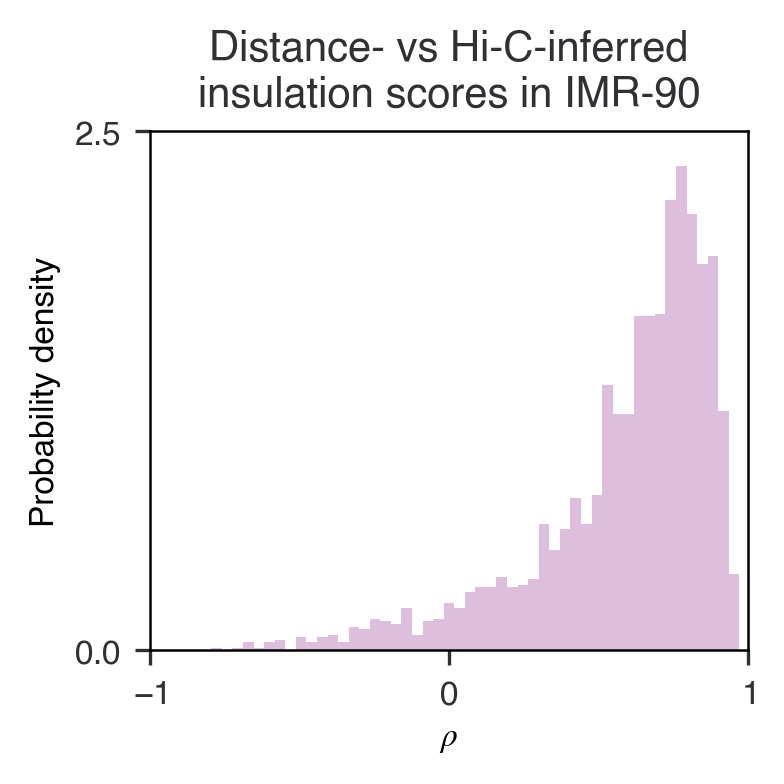

In [10]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(2.5,2.5),layout='constrained')
nbins = 50


pcc_imr = torch.cat([
    imr_data[chrom]['PCC'] for chrom in imr_data
])
pcc_imr = pcc_imr[pcc_imr.isfinite()]

minn = pcc_imr.min()
maxx = pcc_imr.max()
delta = (maxx - minn)/nbins
bins = torch.arange(minn,maxx+delta/2,delta)

for pcc,label in [(pcc_imr,'')]:

    ax.hist(pcc.flatten().cpu().numpy(),density=True,label=label,bins=bins,alpha=.5,edgecolor='none')

#ax.legend(framealpha=0,fontsize='small',loc='upper left')
ax.set_xlim([-1,1])
ax.set_xticks([-1,0,1])
ax.set_ylim([0,2.5])
ax.set_yticks([0,2.5])
ax.set_xlabel('$\\rho$')
ax.set_ylabel('Probability density')
ax.set_title('Distance- vs Hi-C-inferred\ninsulation scores in IMR-90')

fig.savefig(save_folder+'histogram_imr.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'H', 'I', 'M', 'P', 'R', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'hyphen', 'i', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 26, 27, 28, 38, 39, 42, 43, 44, 48, 51, 53, 68, 69, 70, 71, 72, 73, 76, 79, 81, 82, 85, 86, 87, 88, 89, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 40 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef',

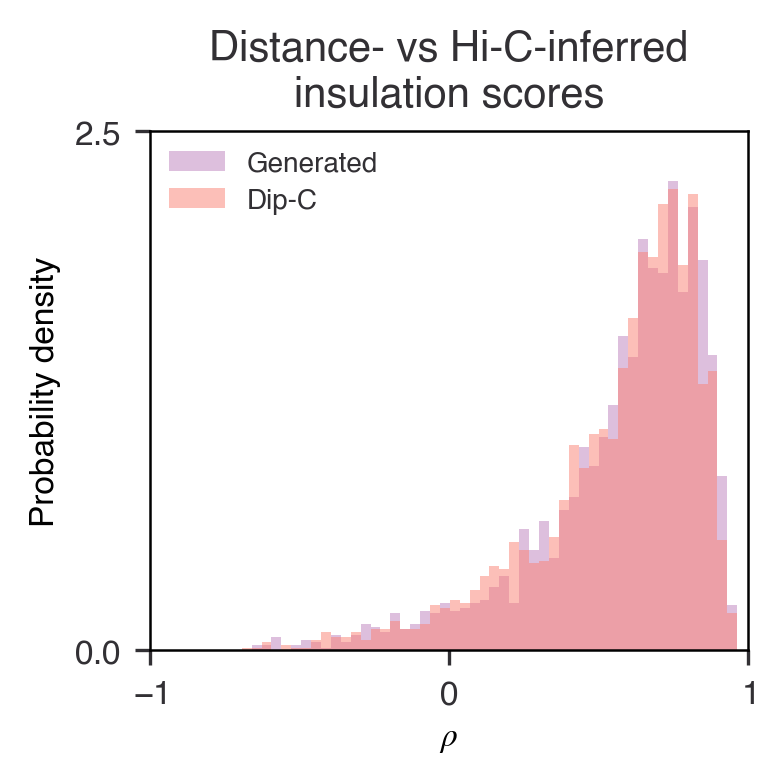

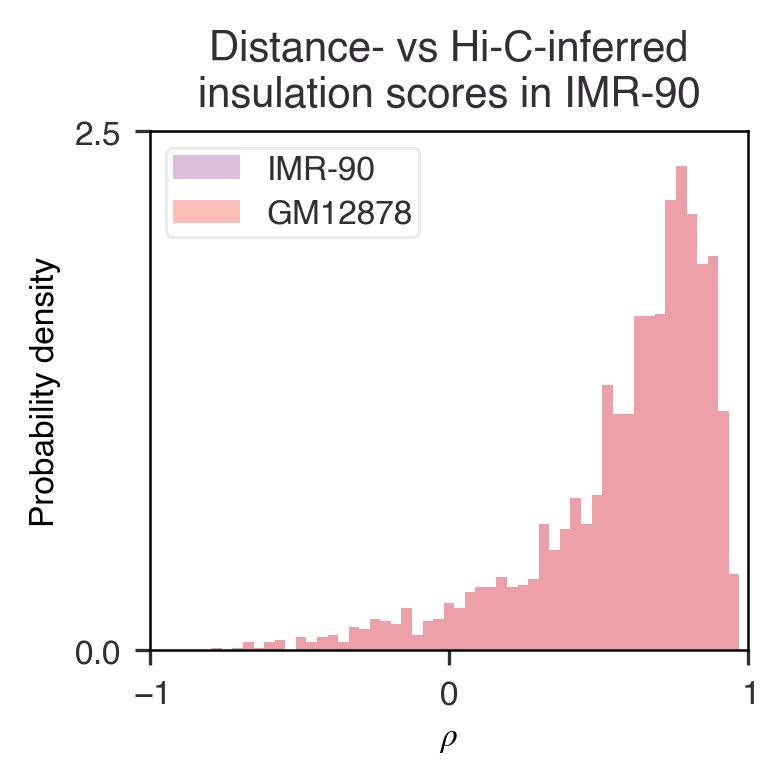

In [11]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(2.5,2.5),layout='constrained')
nbins = 50


pcc_gen = torch.cat([
    data[chrom]['PCC'] for chrom in data
])
pcc_gen = pcc_gen[pcc_gen.isfinite()]

tan_pcc = torch.cat([
    tan_data[chrom]['PCC'] for chrom in tan_data
])
tan_pcc = tan_pcc[tan_pcc.isfinite()]

minn = min( pcc_gen.min(), tan_pcc.min()  )
maxx = max( pcc_gen.max(), tan_pcc.max()  )
delta = (maxx - minn)/nbins
bins = torch.arange(minn,maxx+delta/2,delta)

for pcc,label in [(pcc_gen,'Generated'),(tan_pcc,'Dip-C')]:

    ax.hist(pcc.flatten().cpu().numpy(),density=True,label=label,bins=bins,alpha=.5,edgecolor='none')

ax.legend(framealpha=0,fontsize='small',loc='upper left')
ax.set_xlim([-1,1])
ax.set_xticks([-1,0,1])
ax.set_ylim([0,2.5])
ax.set_yticks([0,2.5])
ax.set_xlabel('$\\rho$')
ax.set_ylabel('Probability density')
ax.set_title('Distance- vs Hi-C-inferred\ninsulation scores')


#####


fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(2.5,2.5),layout='constrained')
nbins = 50


pcc_imr = torch.cat([
    imr_data[chrom]['PCC'] for chrom in imr_data
])
pcc_imr = pcc_imr[pcc_imr.isfinite()]

pcc_gen = torch.cat([
    data[chrom]['PCC'] for chrom in data
])
pcc_gen = pcc_gen[pcc_gen.isfinite()]

minn = min(pcc_imr.min(),pcc_gen.min())
maxx = max(pcc_imr.max(),pcc_gen.max())
delta = (maxx - minn)/nbins
bins = torch.arange(minn,maxx+delta/2,delta)

for pcc,label in [(pcc_imr,'IMR-90'),(pcc_imr,'GM12878')]:

    ax.hist(pcc.flatten().cpu().numpy(),density=True,label=label,bins=bins,alpha=.5,edgecolor='none')

#ax.legend(framealpha=0,fontsize='small',loc='upper left')
ax.set_xlim([-1,1])
ax.set_xticks([-1,0,1])
ax.set_ylim([0,2.5])
ax.set_yticks([0,2.5])
ax.set_xlabel('$\\rho$')
ax.set_ylabel('Probability density')
ax.set_title('Distance- vs Hi-C-inferred\ninsulation scores in IMR-90')

ax.legend()

fig.savefig(save_folder+'histogram_imr_2.pdf')

In [30]:
pcc_tan.median(), pcc_gen.median()

(tensor(0.6407), tensor(0.6501))

In [46]:
vals = [
    0.442,
    14.398,
    28.014,
    39.102,
    49.805,
    59.934,
    69.515,
    78.424,
    86.62,
    94.526,
    102.114,
    109.673,
    117.167,
    123.616,
    129.626,
    135.367,
    140.425,
    144.971,
    149.342,
    152.652,
    156.181,
    158.875,
    161.748,
    170.441
]

for i in range(len(vals)-1):
    print((vals[i]+vals[i+1])/2)

7.42
21.206
33.558
44.4535
54.8695
64.7245
73.96950000000001
82.522
90.57300000000001
98.32
105.8935
113.42
120.39150000000001
126.62100000000001
132.4965
137.89600000000002
142.698
147.1565
150.997
154.41649999999998
157.52800000000002
160.3115
166.09449999999998


In [54]:
180-118.767

61.233000000000004

In [1]:
(194.0521 + 20.3175)/2

107.1848

Developing computational techniques to enable comprehensive studies of single-cell heterogeneity in genome 

New computational techniques enable comprehensive investigations of single-cell heterogeneity in genome organization